# Regresion logistica

Podemos encontrar la documentacion en:  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

En este notebook vamos a ajustar los datos a traves de una regresion logistica.  
Los supuestos del modelo lineal Y = β₀ + β₁ X + ε son que los errores ε tienen media poblacional cero y varianza constante, y que son independientes para distintas observaciones.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from preprocessing import cargarDatasets
from preprocessing import prepararSetDeEntrenamiento
from preprocessing import prepararSetDeValidacion
from preprocessing import ingenieriaDeFeauturesRegresion1
from preprocessing import ingenieriaDeFeauturesRegresion2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV

## Carga y preprocesamiento de los datos

Cargamos los datasets y preparamos los datos para entrenar la regresion.

In [2]:
train_df,final_df = cargarDatasets()
train_df = prepararSetDeEntrenamiento(train_df)

In [3]:
X,y,df,y_encoder = ingenieriaDeFeauturesRegresion1(train_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)

X_2,y_2,df_2,y_encoder_2,meanEncoding = ingenieriaDeFeauturesRegresion2(train_df)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, random_state=117, test_size=0.1, stratify=y_2)

Queremos encontrar los mejores hiperparametros para la regresion. Con estos hiperparametros buscamos minimizar el error en las predicciones, construyendo un modelo robusto y regularizado, para que logre generalizar para datos futuros. Como buscamos elegir el modelo con mejor AUC score, los hiperparametros con los que entrenaremos a la regresion seran los que maximicen el mismo.

Parametros:
* C -> que tanto regularizamos. Similar al C de SVM, cuanto mas pequenio este valor mas fuerte sera la regularizacion.  
* penalty -> tipo de regularizacion, estas pueden ser l1 (lasso), l2 (ridge) o elastic net.


In [4]:
params = [
    {'penalty' : ['l1','l2','elasticnet'],
     'C' : [0.001,0.005,0.01,0.05,0.1,0.3,1,3,5,10,30,50,55,75,100,120,150,],   
    }]

In [5]:
regresion1 = LogisticRegression(random_state = 0)

gscv1 = GridSearchCV(
    regresion1, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")

Best score: 0.8930353283762277
Best params {'C': 0.3, 'penalty': 'l2'}


Obtenemos:  
Best score: 0.8930353283762277  
Best params {'C': 0.3, 'penalty': 'l2'}

In [6]:
regresion2 = LogisticRegression(random_state = 0)

gscv2 = GridSearchCV(
    regresion2, params, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True
).fit(X_train_2, y_train_2)

print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")

Best score: 0.888072427164029
Best params {'C': 0.1, 'penalty': 'l2'}


Obtenemos:  
Best score: 0.888072427164029  
Best params {'C': 0.1, 'penalty': 'l2'}

Nos quedamos con la primera regresion, para la cual obtuvimos un roc score ligeramente mejor. 

In [7]:
params = {'C': 0.1, 'penalty': 'l2'}

regresion1.set_params(**params)
regresion1.fit(X_train, y_train)
y_pred = regresion1.predict(X_test)

## Evaluacion de metricas  
Las metricas a utilizar son:
* AUC-ROC  
* Matriz de confusión  
* Accuracy  
* Precisión  
* Recall 
Primero observamos las metricas obtenidas de las predicciones con el set de prueba.

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, regresion1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2473
           1       0.73      0.56      0.63       784

    accuracy                           0.84      3257
   macro avg       0.80      0.75      0.77      3257
weighted avg       0.83      0.84      0.84      3257



### Curva AUC ROC

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

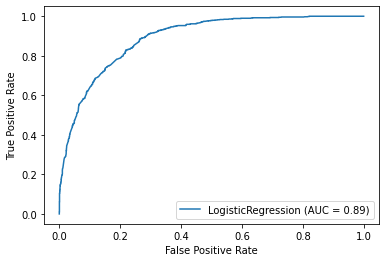

In [10]:
plot_roc_curve(regresion1,X_test,y_test,response_method='predict_proba')
plt.show()

### Matriz de confusion

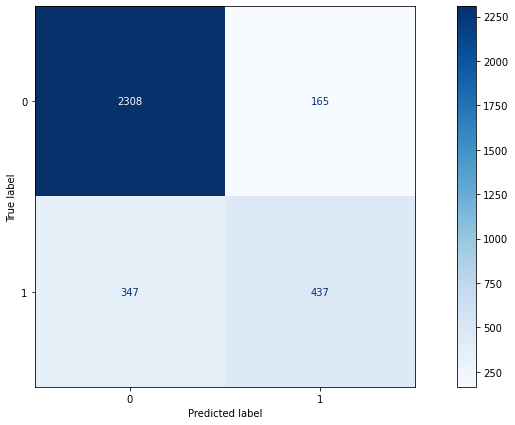

In [11]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    regresion1, X_test, y_test, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax
)
plt.show()

### Accuracy

In [12]:
accuracy_score(y_test, y_pred) 

0.842800122812404

### Precision

In [13]:
precision_score(y_test, y_pred)

0.7259136212624585

### Recall

In [14]:
recall_score(y_test, y_pred)

0.5573979591836735

### Residual plot
Queremos observar que los residuos cumplan con los supuestos del modelo. Si no se cumplen, tal vez el modelo lineal no sea lo mejor para predecir

<AxesSubplot:xlabel='Predicciones', ylabel='Residuos'>

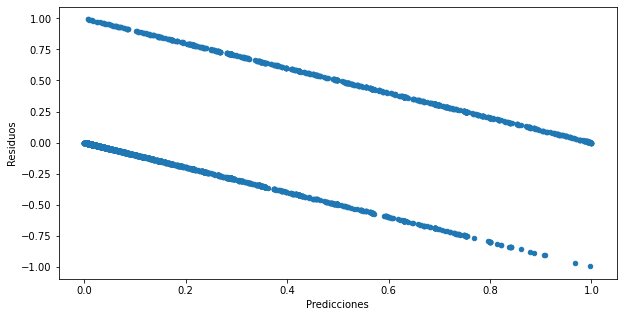

In [15]:
plt.rcParams['figure.figsize'] = (10, 5)

y_pred_proba = regresion1.predict_proba(X_test)[:,1]

preds = pd.DataFrame({"Predicciones": y_pred_proba, "true": y_test})
preds["Residuos"] = preds["true"] - preds["Predicciones"]
preds.plot(x="Predicciones", y="Residuos", kind="scatter")

Podemos concluir que este modelo lineal tal vez no sea el mejor para predecir la variable target ya que podemos ver un patron en el grafico de residuos.

## Predicciones sobre el set de hold out

In [16]:
from preprocessing import prepararSetDeHoldOutRegresion

In [17]:
final_df = prepararSetDeHoldOutRegresion(final_df)

#agrego dos columnas qu faltan por no haber labels
final_df['categoria_de_trabajo_empleadao_estatal'] = 0
final_df['trabajo_directivo_gerente'] = 0

ho_prediction = regresion1.predict(final_df)
final_df['tiene_alto_valor_adquisitivo'] = ho_prediction

final_df.to_csv('predicciones/regresion.csv')